## Wstęp

Po pierwszym zadaniu można wyciągnąć wiele wniosków, ale skupię się na tych najważniejszych

* Sex -> Kobiety mają znacznie większe szansę na przeżycie
* Age -> dzieci mają większe szanse na przeżcyie, najmniejsze starsi
* Fare == Kaska -> im więcej wydane tym łatwiej przeżyć 

Na późniejszym etapie zobaczymy czy te hipotezy się sprawdzą

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('titanic.csv')

Klasyczna zabawa danymi, żeby wszystko działało

In [3]:
print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare            98
Cabin          687
Embarked         2
dtype: int64


* Age zamieniami medianom pomysł podrkadziony od Julii z prezentacji
* Wywalam cabin name passengerid i ticket -> useless, można myśleć na temat cabin, ale pod pierwszym zadaniem uargumentowałem czemu tak robię 
* embarked ustawiamy dominanta -> s-ka
* Fare -> medianka
* Dodaje familysize jakos sibsp + parch + 1

In [4]:
df['Fare'] = df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median())) # Fajny pomysł z prezentacji od Julii
df.drop(['Cabin','Name', 'PassengerId', 'Ticket'],axis = 1,inplace=True)
df = df.fillna({'Embarked': 'S'})
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

In [5]:
df['Sex'] = df['Sex'].map({'male':1, 'female':0})

In [6]:
print(df.isnull().sum())

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
FamilySize    0
dtype: int64


In [7]:
df = pd.get_dummies(df, columns=['Embarked', 'Pclass'])

Korelacja była opsiana w 1, więc skipnę 

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report

In [9]:
from sklearn.model_selection import train_test_split

X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
df.head()

,Survived,Sex,Age,SibSp,Parch,Fare,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,1,22.0,1,0,7.2500,2,False,False,True,False,False,True
1,1,0,38.0,1,0,71.2833,2,True,False,False,True,False,False
2,1,0,26.0,0,0,7.9250,1,False,False,True,False,False,True
3,1,0,35.0,1,0,53.1000,2,False,False,True,True,False,False
4,0,1,35.0,0,0,8.0500,1,False,False,True,False,False,True


## Decision Tree 

Poszukiwanie najlepszych parametrów używając gridsearch, tutaj nie potrzeba zbioru validacyjnego, ponieważ korzystamy z crossvalidacji, a dokladniej 5 k-foldow ( model trenuje na k-1 foldach, a validuje na tym k-tym i tak sie iteruje po wszystkich i wybiera najlepsze parametry (srednia po wszystkich foldach))

Best parameters: {'max_depth': 7, 'min_samples_split': 10}
Best cross-validation score (F1): 0.73
Test set score (F1): 0.69
Accuracy: 0.7877

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       107
           1       0.84      0.58      0.69        72

    accuracy                           0.79       179
   macro avg       0.80      0.75      0.76       179
weighted avg       0.80      0.79      0.78       179



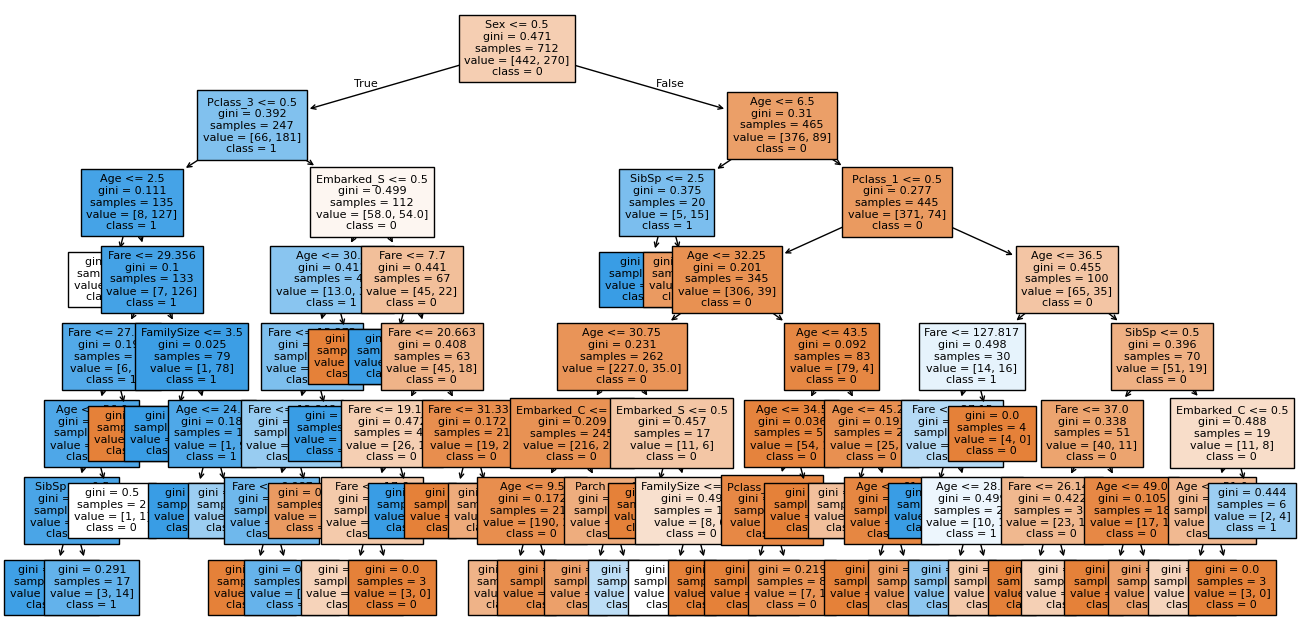

In [11]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

param_grid = {
    'max_depth': range(1, 25),
    'min_samples_split': range(2, 25)
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(criterion='gini', random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print('Best parameters:', grid_search.best_params_)
print('Best cross-validation score (F1):', f'{grid_search.best_score_:.2f}')

best_tree = grid_search.best_estimator_
test_score = grid_search.score(X_test, y_test)
print('Test set score (F1):', f'{test_score:.2f}')

y_pred = best_tree.predict(X_test)
y_pred_proba = best_tree.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(16,8))
plot_tree(best_tree, filled=True, feature_names=X_train.columns, class_names=['0','1'], fontsize=8)
plt.show()


Wynik typu gitarka, gridsearch pozwala fajnie znaleźć najbardziej optymalne parametry stosunkowo szybko

## Random Forest

do rfc skorzystam z randomized searcha, bo troche dlugo sie trenuje dla tak wielu parametrow jak uzywalem normalnego grid searcha

In [12]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 5, 10, 15, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

randomForest = RandomForestClassifier()

from sklearn.model_selection import RandomizedSearchCV
grid_search = RandomizedSearchCV(
    estimator=randomForest,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='f1',
)

grid_search.fit(X_train, y_train)

print('Best parameters:', grid_search.best_params_)
print('Best cross-validation score:', grid_search.best_score_)

test_score = grid_search.score(X_test, y_test)
print('Test set accuracy:', test_score)

Best parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'entropy'}
Best cross-validation score: 0.7663871382091895
Test set accuracy: 0.7633587786259542


In [13]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.86       107
           1       0.85      0.69      0.76        72

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



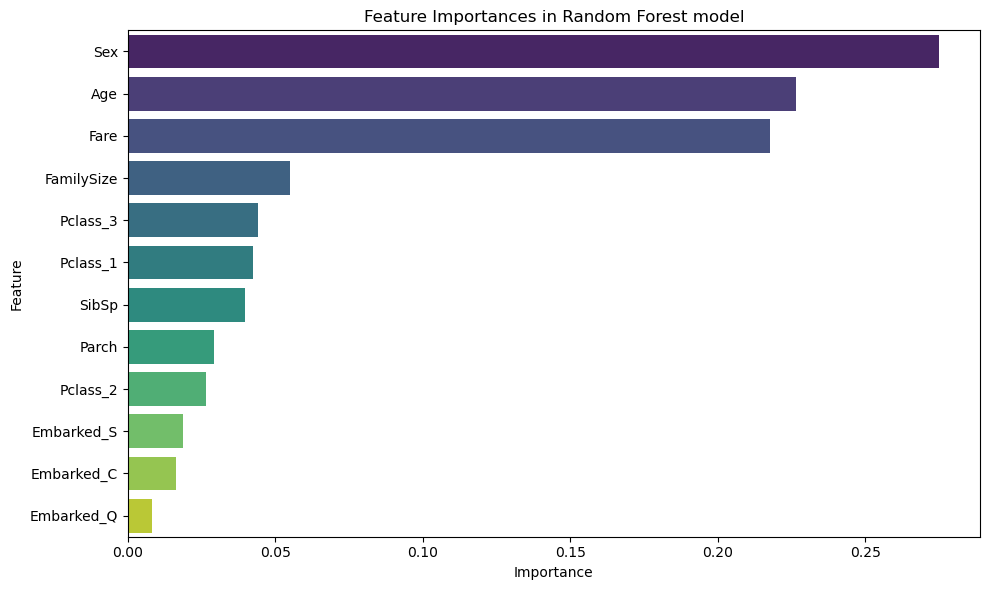

In [14]:
importances = best_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_n = 15
feature_importance_df = feature_importance_df.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    order=feature_importance_df['Feature'],
    palette='viridis'
)
plt.title('Feature Importances in Random Forest model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## LightGBM

We can also use a tree-based model such as LightGBM, a gradient boosting framework that uses tree-based learning algorithms

In [15]:
import lightgbm as lgbm

param_grid = {
    'num_leaves': [15, 31, 63, 127],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

model = lgbm.LGBMClassifier(objective='binary', boosting_type='gbdt', n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='f1',
    n_jobs=-1,
)

random_search.fit(X_train, y_train)
print('Best parameters:', random_search.best_params_)
print(f'Best cross-validation accuracy: {random_search.best_score_:.4f}')

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test set accuracy: {accuracy:.4f}')


print('Classification Report:')
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

[LightGBM] [Info] Number of positive: 270, number of negative: 442
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.379213 -> initscore=-0.492888
[LightGBM] [Info] Start training from score -0.492888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

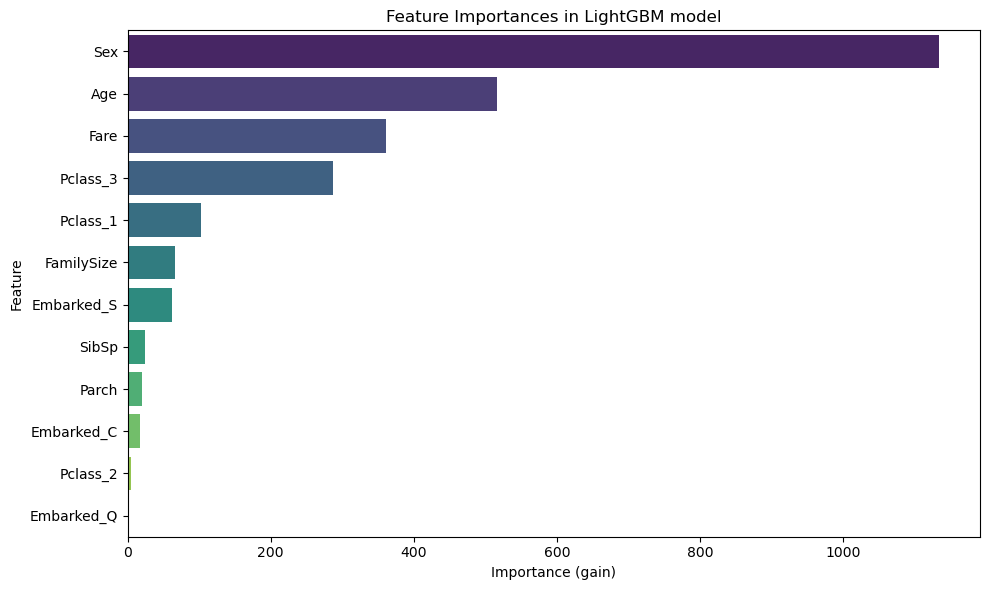

In [16]:
importances = best_model.booster_.feature_importance(importance_type='gain')
feature_names = best_model.booster_.feature_name()

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    order=feature_importance_df['Feature'],
    palette='viridis'
)
plt.title('Feature Importances in LightGBM model')
plt.xlabel('Importance (gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Tak w formie podsumowania, to wsztskie modele potwierdzają hipotezy z EDY oraz wszystkie się skupiają na podobnych featurach

Wszystkie modele osiągnęły satysfakcjonujące wyniki, wiadomo basicowe decison tree ma ciutke mniej, od random forest i gradientowego drzewka, ale jest gitarka